# Промышленность. Предсказание температуры сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

***Задача:*** построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

***Метрика для оценки качества:*** MAE < 6.8.

**Описание процесса обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.


Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.


Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.


Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

**Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.


*Таблица steel.data_arc*

- key — номер партии;
- BeginHeat — время начала нагрева;
- EndHeat — время окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.


*Таблица steel.data_bulk*

- key — номер партии;
- Bulk1 … Bulk15 — объём подаваемого материала.


*Таблица steel.data_bulk_time*

- key — номер партии;
- Bulk1 … Bulk15 — время подачи материала.


*Таблица steel.data_gas*

- key — номер партии;
- gas — объём подаваемого газа.


*Таблица steel.data_temp*

- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.


*Таблица steel.data_wire*

- key — номер партии;
- Wire1 … Wire15 — объём подаваемых проволочных материалов.


*Таблица steel.data_wire_time*

- key — номер партии;
- Wire1 … Wire15 — время подачи проволочных материалов.


Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка данных

In [2]:
!pip install -q skorch

In [3]:
from sqlalchemy import create_engine
import pandas as pd 
import numpy as np
from datetime import time 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import SCORERS, mean_absolute_error, r2_score  
from catboost import CatBoostRegressor 
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor 
from skorch.dataset import ValidSplit

In [4]:
# подключение к базе данных
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [5]:
# константа для рандома
RANDOM_STATE = 190623

In [6]:
if torch.cuda.is_available():
    DEVICE    = 'cuda'   # для pytorch
    TASK_TYPE = 'GPU'    # для catboost
else:
    DEVICE    = 'cpu'    # для pytorch
    TASK_TYPE = 'CPU'    # для catboost

## Исследовательский анализ и предобработка данных

### Проверка данных

Проверим, все ли таблицы содержат данные и соответствует ли количество таблиц условию задачи.

In [7]:
# данные об электродах
query = '''
SELECT *
FROM steel.data_arc;
'''

data_arc = pd.read_sql_query(query, con=engine) 

In [8]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [9]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [10]:
# данные об объёме сыпучих материалов
query = '''
SELECT *
FROM steel.data_bulk;
'''

data_bulk = pd.read_sql_query(query, con=engine) 

In [11]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [12]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Здесь данные есть не во всех столбцах. Одна итерация соответствует одному из значений объёма подаваемого материала. 

In [13]:
# данные о времени подачи сыпучих материалов
query = '''
SELECT *
FROM steel.data_bulk_time;
'''

data_bulk_time = pd.read_sql_query(query, con=engine) 

In [14]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


In [15]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Пропуски в колонках соответствуют пропускам из предыдущей таблицы, как и должно быть.

In [16]:
# данные о продувке сплава газом
query = '''
SELECT *
FROM steel.data_gas;
'''

data_gas = pd.read_sql_query(query, con=engine) 

In [17]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [19]:
#  данные об измерениях температуры
query = '''
SELECT *
FROM steel.data_temp;
'''

data_temp = pd.read_sql_query(query, con=engine) 

In [20]:
data_temp.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [21]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Здесь не хватает данных о значении температуры.

In [22]:
# данные об объёме проволочных материалов
query = '''
SELECT *
FROM steel.data_wire;
'''

data_wire = pd.read_sql_query(query, con=engine) 

In [23]:
data_wire.head() 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Здесь, видимо, в скольких итерациях подавались проволочные материалы, в стольких колонках и есть данные по каждой строке.

In [25]:
# данные о времени подачи проволочных материалов
query = '''
SELECT *
FROM steel.data_wire_time;
'''

data_wire_time = pd.read_sql_query(query, con=engine) 

In [26]:
data_wire_time.head() 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


In [27]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Количество данных соответствует количеству данных из предыдущей таблицы.

Все таблицы содержат данные, количество таблиц соответствует условию задачи.

### data_arc

Для таблицы steel.data_arc:
- проверим наличие пропусков и аномалий, изучим распределение признаков
- сгенерируем новые признаки, которые могут пригодиться при обучении

#### Пропуски и аномалии

In [28]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


Колонки `BeginHeat` и `EndHeat` содержат время - необходимо проверить, чтобы время начала было раньше времени окончания нагрева.

In [29]:
# находим строки, в которых не совпадает последовательность по времени
t = data_arc['BeginHeat'] < data_arc['EndHeat']
t = t[t == 0]
data_arc.loc[t.index, :]

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
580,126,23:59:35,00:01:55,0.527388,0.405463
1170,257,23:58:57,00:00:07,0.268811,0.175647
1280,280,23:56:57,00:01:43,1.197192,0.728587
1953,421,23:58:33,00:01:57,0.774585,0.583186
2952,642,23:52:55,00:03:13,2.415316,1.946081
3438,745,23:58:27,00:00:14,0.403792,0.281718
4250,913,23:58:22,00:01:34,0.787956,0.537366
4752,1026,23:59:04,00:07:07,1.680239,1.400063
5400,1175,23:59:25,00:05:07,1.325558,0.893414
6456,1404,23:56:33,00:01:05,1.217748,0.833978


Здесь уже идёт переход в следующие сутки, значит, всё хорошо.

In [30]:
# смотрим стастистику по значениям
data_arc[['ActivePower', 'ReactivePower']].describe()

,ActivePower,ReactivePower
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


В колонке `ReactivePower` есть аномальное значение.

In [31]:
data_arc.query('ReactivePower <= 0')

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
9781,2116,00:44:48,00:46:37,0.495782,-715.504924


Аномальное значение всего одно, поэтому будет проще удалить его из выборки.

In [32]:
data_arc = data_arc.query('ReactivePower > 0')

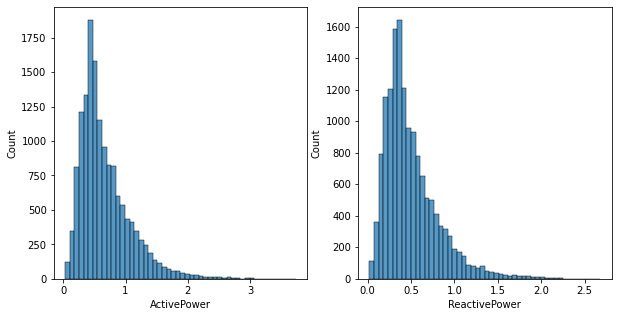

In [33]:
# строим графики распределения значений
powers = data_arc[['ActivePower', 'ReactivePower']]

fig = plt.figure(figsize=(10,5))

for i in range(powers.shape[1]):
    
    fig.add_subplot(1, 2, i+1)
    sns.histplot(powers.loc[:,powers.columns[i]], bins=50)

plt.show()

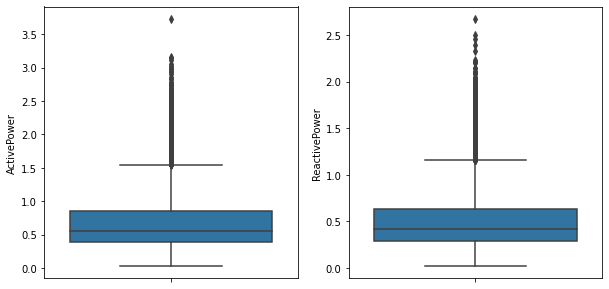

In [34]:
# строим графики размаха значений
fig = plt.figure(figsize=(10,5))

for i in range(powers.shape[1]):
    
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(y=powers.loc[:,powers.columns[i]])

plt.show()

Оба графика значений имеют нормальное распределение и скошенность влево.

In [35]:
# смотрим пропуски
data_arc.isna().sum()

key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64

In [36]:
# смотрим дубликаты
data_arc.duplicated().sum()

0

#### Генерация новых признаков

- *Длительность нагрева*

Сгенерируем новый признак: длительность нагрева. Он будет равен разнице между `BeginHeat`и `EndHeat` в секундах.

In [37]:
data_arc['HeatingDuration'] = (pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S') - pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S')).dt.seconds

- *Общая мощность*

Общая мощность - сумма активной и реактивной мощностей.

In [38]:
data_arc['TotalPower'] = (data_arc['ActivePower'] + data_arc['ReactivePower'])

- *Соотношение активной мощности к реактивной*

In [39]:
data_arc['ActiveReactiveRatio'] = (data_arc['ActivePower'] / data_arc['ReactivePower'])

- *Агрегированные по каждой партии значения*

Далее для каждой партии получим агрегированные значения.

In [40]:
new_features = data_arc.groupby('key').agg({'HeatingDuration':'sum',
                             'TotalPower':'sum',
                             'ActivePower':'sum',
                             'ReactivePower':'sum'}).rename(columns={'HeatingDuration':'TotalHeatingDuration',
                                                                     'TotalPower':'AllPower',
                                                                     'ActivePower':'TotalActivePower',
                                                                     'ReactivePower':'TotalReactivePower'})

In [41]:
new_features['TotalActiveReactiveRatio'] = new_features['TotalActivePower']/new_features['TotalReactivePower']

- *Количество итераций нагрева электродами*

In [42]:
iteration_cnt = data_arc.groupby('key').agg({'ActivePower':'count'})

In [43]:
new_features['IterationCnt'] = iteration_cnt

In [44]:
new_features.head()

,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt
key,,,,,,
1,1098,8.061388,4.878147,3.183241,1.532447,5
2,811,5.050710,3.052598,1.998112,1.527741,4
3,655,4.124958,2.525882,1.599076,1.579589,5
4,741,5.269548,3.209250,2.060298,1.557663,4
5,869,5.599815,3.347173,2.252643,1.485887,4


Присоединим новые признаки к таблице.

In [45]:
data_arc = data_arc.join(new_features, on='key', how='left')

Т.к. теперь у нас есть признак длительности нагрева, колонки `BeginHeat` и `EndHeat` можно удалить.

In [46]:
data_arc = data_arc.drop(columns=['BeginHeat', 'EndHeat']) 

In [47]:
data_arc.head()

,key,ActivePower,ReactivePower,HeatingDuration,TotalPower,ActiveReactiveRatio,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt
0,1,0.976059,0.687084,228,1.663142,1.420582,1098,8.061388,4.878147,3.183241,1.532447,5
1,1,0.805607,0.520285,185,1.325892,1.548395,1098,8.061388,4.878147,3.183241,1.532447,5
2,1,0.744363,0.498805,172,1.243169,1.492292,1098,8.061388,4.878147,3.183241,1.532447,5
3,1,1.659363,1.062669,365,2.722032,1.561504,1098,8.061388,4.878147,3.183241,1.532447,5
4,1,0.692755,0.414397,148,1.107152,1.671717,1098,8.061388,4.878147,3.183241,1.532447,5


In [48]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   key                       14875 non-null  int64  
 1   ActivePower               14875 non-null  float64
 2   ReactivePower             14875 non-null  float64
 3   HeatingDuration           14875 non-null  int64  
 4   TotalPower                14875 non-null  float64
 5   ActiveReactiveRatio       14875 non-null  float64
 6   TotalHeatingDuration      14875 non-null  int64  
 7   AllPower                  14875 non-null  float64
 8   TotalActivePower          14875 non-null  float64
 9   TotalReactivePower        14875 non-null  float64
 10  TotalActiveReactiveRatio  14875 non-null  float64
 11  IterationCnt              14875 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.5 MB


### data_bulk

- Проверим наличие пропусков и аномалий, изучим распределение признаков.
- Обработаем пропуски.

In [49]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [50]:
# смотрим статистику данных
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


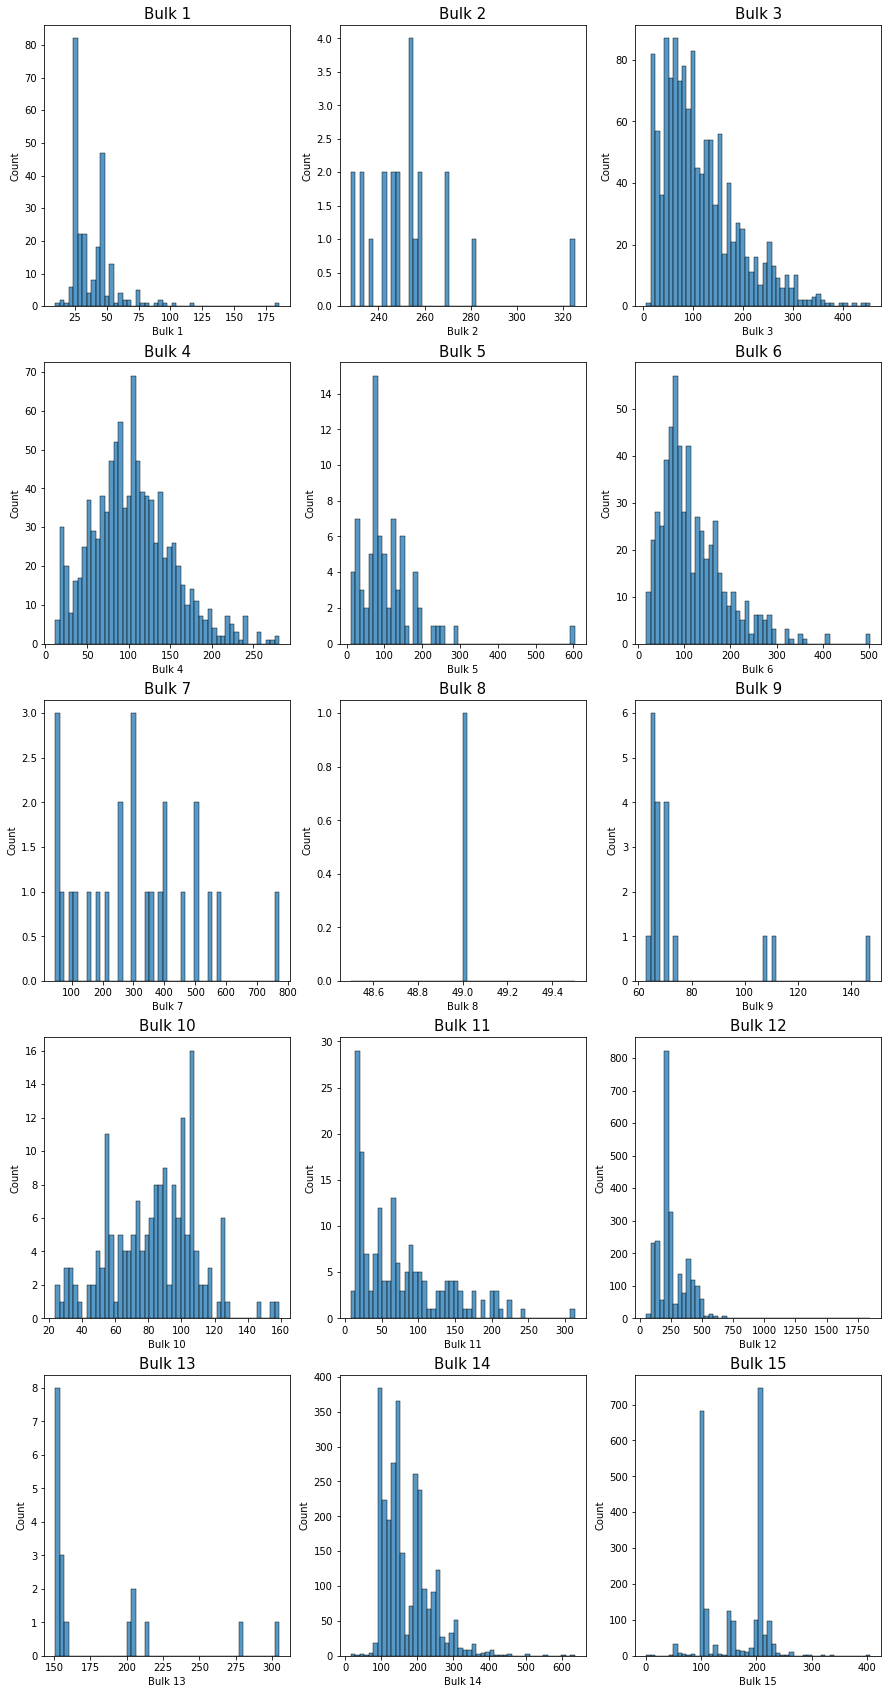

In [51]:
# строим графики распределения значений
bulks = data_bulk.drop('key', axis=1) 

fig = plt.figure(figsize=(15,30))

for i in range(bulks.shape[1]):
    
    fig.add_subplot(5, 3, i+1)
    plt.title(bulks.columns[i], fontsize=15)
    sns.histplot(bulks.loc[:,bulks.columns[i]], bins=50)

plt.show()

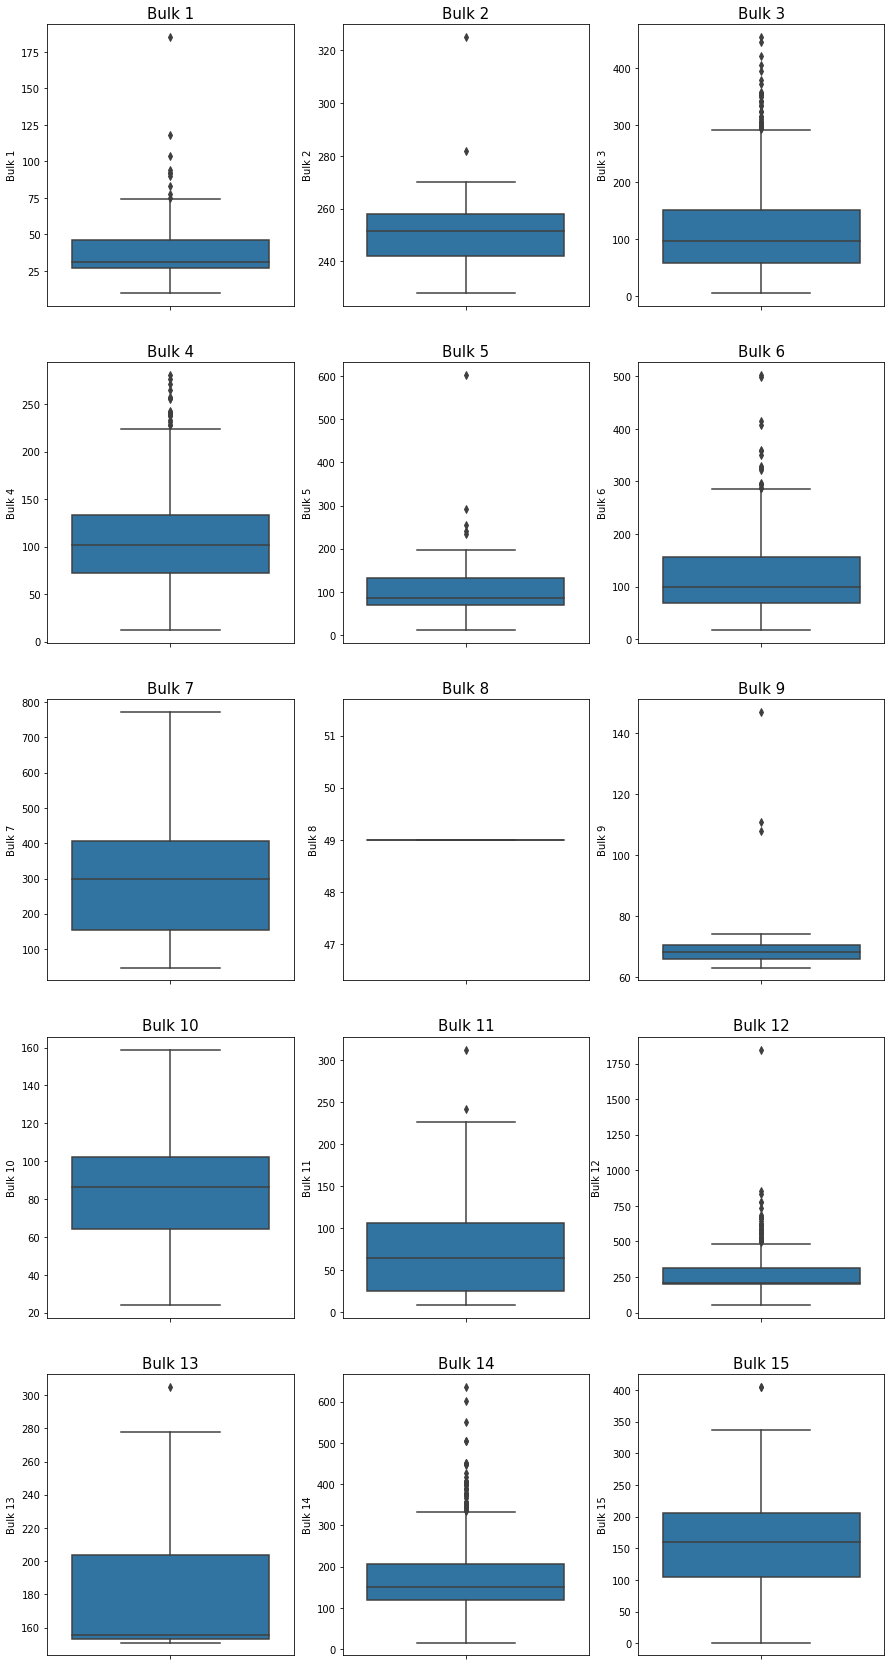

In [52]:
fig = plt.figure(figsize=(15,30))

for i in range(bulks.shape[1]):
    
    fig.add_subplot(5, 3, i+1)
    plt.title(bulks.columns[i], fontsize=15)
    sns.boxplot(y=bulks.loc[:,bulks.columns[i]])

plt.show()

Среди графиков особо выделяется `Bulk12` - посмотрим на выбросное значение.

In [53]:
data_bulk[data_bulk['Bulk 12'] > 1000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


В этой партии видно, что добавляли много материалов. Возможно, тогда значение не является аномальным.

Т.к. пропуск означает, что материал не добавляли в партию, пропуски лучше всего заменить нулевыми значениями.

In [54]:
data_bulk = data_bulk.fillna(0)

### data_bulk_time

- Проверим наличие пропусков и аномалий, изучим распределение признаков.
- Проверим данные на адекватность и убедимся, что подача материала не измеряется сутками.

In [55]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


In [56]:
for column in bulks.columns:
    print(bulks[column].unique())

[ nan  46.  27.  48.  29.  78.  52.  69.  51.  73.  92.  65.  75.  94.
 185.  67.  37.  10.  43.  34.  54.  44.  39.  90.  62.  60.  31.  33.
  50.  83.  58.  41.  38.  30.  63.  19.  21.  47. 118.  28.  36.  22.
  32.  24. 104.  74.  26.  16.]
[ nan 228. 247. 232. 325. 257. 233. 242. 248. 249. 282. 258. 270. 246.
 254. 236.]
[ nan  71. 151.  63.  89. 132.  67.  19.  21.  44. 244. 243. 182.  83.
  81. 146. 149.  70.  53. 122. 152. 102.  23.  29.  69.  72. 141.  62.
 349. 261.  92.  80. 123. 213. 305. 249. 171. 300. 262. 114. 198. 202.
 315. 334. 220. 153. 124.  17.  91.  79. 115. 133. 199. 101.  68.  74.
  52.  49. 131.  42. 226. 126.  60.  90.  36. 211. 301. 214. 190. 172.
  59.  87. 246. 121. 116.  99.  93.  57. 177.  55. 119. 134. 165. 139.
  25. 342. 174. 308. 286. 289. 138.  34.  38. 191. 290.  65.  95. 206.
  37. 109.  40. 154. 100. 245. 128.  51. 272. 270. 353. 106. 335. 117.
 197. 120. 137.  66. 144.  46. 193. 155. 248.  26. 239. 189. 298.  97.
 125. 256. 143. 266. 183.  94. 40

Пока не очень понятно, что это за значения и как их использовать.

### data_gas

Для таблицы steel.data_gas:
  
Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

In [57]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [58]:
# смотрим пропуски
data_gas.isna().sum()

key    0
gas    0
dtype: int64

In [59]:
# смотрим статистику
data_gas['gas'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

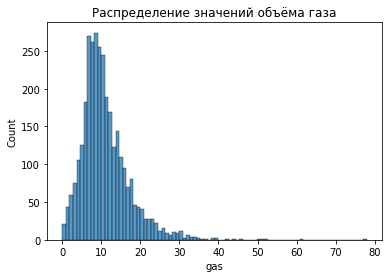

In [60]:
# строим график распределения
sns.histplot(data_gas['gas'])
plt.title('Распределение значений объёма газа')
plt.show()

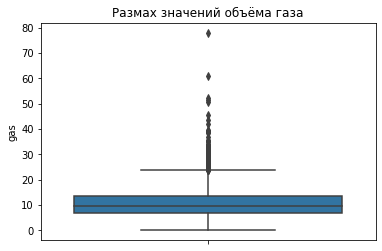

In [61]:
# строим график размаха
sns.boxplot(y=data_gas['gas'])
plt.title('Размах значений объёма газа')
plt.show()

Несмотря на большой размах значений, сильно неадекватных выбросов нет.

### data_temp

In [62]:
data_temp.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


В колонке с температурой есть пропуски: надо проверить, есть ли пропуски в целевых значениях.

In [63]:
data_temp['Temperature'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Temperature, dtype: float64

Известно, что температура ниже 1500 - это аномалия. Посмотрим, сколько аномальных значений.

In [64]:
data_temp.query('Temperature < 1500')

,key,MesaureTime,Temperature
4350,867,14:21:00,1191.0
5978,1214,05:32:00,1208.0
7958,1619,11:03:54,1218.0
8913,1818,00:30:49,1383.0
8914,1818,00:31:40,1383.0
10127,2052,14:51:40,1227.0
12564,2561,07:34:15,1204.0


Эти записи лучше удалить из выборки.

In [65]:
data_temp = data_temp.query('Temperature >= 1500')

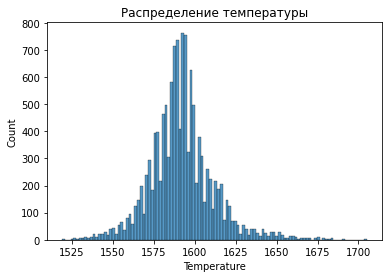

In [66]:
# строим график распределения температуры
sns.histplot(data_temp['Temperature'])
plt.title('Распределение температуры')
plt.show()

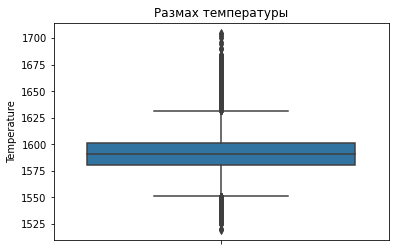

In [67]:
# строим график размаха температуры
sns.boxplot(y=data_temp['Temperature'])
plt.title('Размах температуры')
plt.show()

В качестве признаков для обучения можно взять только первое значение температуры - все остальные приведут к утечке целевого признака.

In [68]:
first_temperature = data_temp.groupby('key').agg({'key':'count',
                              'Temperature':'first'}).query('key >= 2')

In [69]:
first_temperature.isna().sum()

key            0
Temperature    0
dtype: int64

In [70]:
first_temperature.head()

,key,Temperature
key,,
1,5,1571.0
2,6,1581.0
3,5,1596.0
4,3,1601.0
5,2,1576.0


In [71]:
target = data_temp.groupby('key').agg({'key':'count',
                              'Temperature':'last'}).query('key >= 2')

In [72]:
target.head()

,key,Temperature
key,,
1,5,1613.0
2,6,1602.0
3,5,1599.0
4,3,1625.0
5,2,1602.0


### data_wire

Для таблицы steel.data_wire:
  
Обработайте пропуски. Пропуск означает, что материал не добавляли в эту партию

In [73]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Т.к. пропуск обозначает, что этот материал не добавляли в партию, то пропуски можно заполнить нулевыми значениями.

In [74]:
data_wire = data_wire.fillna(0)

In [75]:
data_wire.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

### data_wire_time

Для таблицы steel.data_wire_time:
  
Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [76]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


In [77]:
for column in data_wire.drop('key', axis=1):
    print(data_wire_time[column].value_counts())

07:26:50    2
20:49:20    2
00:15:25    2
08:32:47    2
19:26:52    2
           ..
13:54:50    1
11:56:10    1
03:45:00    1
13:17:58    1
17:05:17    1
Name: Wire 1, Length: 3000, dtype: int64
21:37:29    2
19:57:26    2
11:15:54    2
05:13:57    2
18:29:22    1
           ..
06:31:57    1
14:21:55    1
02:44:56    1
00:51:49    1
01:08:45    1
Name: Wire 2, Length: 1075, dtype: int64
19:25:35    1
14:40:37    1
08:50:52    1
02:11:18    1
15:27:54    1
           ..
13:19:54    1
17:43:23    1
22:01:36    1
21:58:49    1
20:37:44    1
Name: Wire 3, Length: 63, dtype: int64
16:09:18    1
12:03:12    1
10:16:15    1
11:25:32    1
08:48:23    1
11:12:30    1
11:52:57    1
08:44:49    1
18:09:32    1
07:15:28    1
14:40:29    1
15:42:50    1
09:00:26    1
10:14:55    1
Name: Wire 4, dtype: int64
16:01:07    1
Name: Wire 5, dtype: int64
18:10:03    1
15:37:45    1
03:28:47    1
19:30:11    1
10:16:47    1
           ..
20:57:55    1
23:44:52    1
14:53:47    1
14:29:00    1
14:12:27    1

Может быть этот признак потом пригодится для генерации других признаков.

### Объединение признаков

Объедините таблицы по ключу:
  
Каждой партии должно соответствовать одно наблюдение.
Учтите: во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.
Заказчик предупредил, что иногда наблюдается асинхронность в заданном времени разных датчиков. Если вы будете выстраивать хронологию процессов для разных партий, то можете столкнуться с тем, что полученная хронология не соответствует хронологии в описании. Не стоит воспринимать это как ошибку.
Проведите исследовательский анализ данных объединённой таблицы и визуализируйте распределение каждого признака, напишите выводы.
Проведите корреляционный анализ.

В итоговой таблице каждой партии должно соответствовать одно наблюдение. Будем делать объединение поэтапно.

In [78]:
data_arc.head()

,key,ActivePower,ReactivePower,HeatingDuration,TotalPower,ActiveReactiveRatio,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt
0,1,0.976059,0.687084,228,1.663142,1.420582,1098,8.061388,4.878147,3.183241,1.532447,5
1,1,0.805607,0.520285,185,1.325892,1.548395,1098,8.061388,4.878147,3.183241,1.532447,5
2,1,0.744363,0.498805,172,1.243169,1.492292,1098,8.061388,4.878147,3.183241,1.532447,5
3,1,1.659363,1.062669,365,2.722032,1.561504,1098,8.061388,4.878147,3.183241,1.532447,5
4,1,0.692755,0.414397,148,1.107152,1.671717,1098,8.061388,4.878147,3.183241,1.532447,5


Из этой таблицы возьмём признаки `TotalHeatingDuration`, `AllPower`, `TotalActivePower`, `TotalReactivePower`, `TotalActiveReactiveRatio`, `IterationCnt`, которые характеризуют партию в целом.

In [79]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Отсюда берём все признаки.

In [80]:
data_arc = data_arc.groupby('key').agg({
                             'TotalHeatingDuration':'first',
                             'AllPower':'first',
                             'TotalActivePower':'first',
                             'TotalReactivePower':'first',
                             'TotalActiveReactiveRatio':'first',
                             'IterationCnt':'first'})

Проверим количество данных в обеих таблицах.

In [81]:
data_arc.shape, data_bulk.shape

((3214, 6), (3129, 16))

In [82]:
data_arc.head()

,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt
key,,,,,,
1,1098,8.061388,4.878147,3.183241,1.532447,5
2,811,5.050710,3.052598,1.998112,1.527741,4
3,655,4.124958,2.525882,1.599076,1.579589,5
4,741,5.269548,3.209250,2.060298,1.557663,4
5,869,5.599815,3.347173,2.252643,1.485887,4


In [83]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [84]:
data = data_arc.merge(data_bulk, on='key', how='inner')

In [85]:
data.head()

,key,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt,Bulk 1,Bulk 2,Bulk 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,1098,8.061388,4.878147,3.183241,1.532447,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,811,5.050710,3.052598,1.998112,1.527741,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,655,4.124958,2.525882,1.599076,1.579589,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,741,5.269548,3.209250,2.060298,1.557663,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,869,5.599815,3.347173,2.252643,1.485887,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3127
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   key                       3128 non-null   int64  
 1   TotalHeatingDuration      3128 non-null   int64  
 2   AllPower                  3128 non-null   float64
 3   TotalActivePower          3128 non-null   float64
 4   TotalReactivePower        3128 non-null   float64
 5   TotalActiveReactiveRatio  3128 non-null   float64
 6   IterationCnt              3128 non-null   int64  
 7   Bulk 1                    3128 non-null   float64
 8   Bulk 2                    3128 non-null   float64
 9   Bulk 3                    3128 non-null   float64
 10  Bulk 4                    3128 non-null   float64
 11  Bulk 5                    3128 non-null   float64
 12  Bulk 6                    3128 non-null   float64
 13  Bulk 7                    3128 non-null   float64
 14  Bulk 8  

Идём дальше.

In [87]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


В этой таблице значения в странных измерениях, поэтому пока не будем использовать.

In [88]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [89]:
data_gas.shape

(3239, 2)

Объём газа включаем в таблицу.

In [90]:
data = data.merge(data_gas, on='key', how='inner')

In [91]:
data.head()

,key,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt,Bulk 1,Bulk 2,Bulk 3,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
0,1,1098,8.061388,4.878147,3.183241,1.532447,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,811,5.050710,3.052598,1.998112,1.527741,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,655,4.124958,2.525882,1.599076,1.579589,5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,741,5.269548,3.209250,2.060298,1.557663,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,869,5.599815,3.347173,2.252643,1.485887,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


In [92]:
first_temperature.drop('key', axis=1).head()

,Temperature
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0


In [93]:
data = data.merge(first_temperature.drop('key', axis=1), on='key', how='inner')

In [94]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
data_wire.shape

(3081, 10)

Все признаки берём.

In [96]:
data = data.merge(data_wire, on='key', how='inner')

И, наконец, добавляем целевой признак.

In [97]:
data = data.merge(target.drop('key', axis=1), on='key', how='inner')

In [98]:
data = data.drop('key', axis=1)

In [99]:
data.head()

,TotalHeatingDuration,AllPower,TotalActivePower,TotalReactivePower,TotalActiveReactiveRatio,IterationCnt,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Temperature_y
0,1098,8.061388,4.878147,3.183241,1.532447,5,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1613.0
1,811,5.050710,3.052598,1.998112,1.527741,4,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0
2,655,4.124958,2.525882,1.599076,1.579589,5,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1599.0
3,741,5.269548,3.209250,2.060298,1.557663,4,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1625.0
4,869,5.599815,3.347173,2.252643,1.485887,4,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1602.0


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalHeatingDuration      2329 non-null   int64  
 1   AllPower                  2329 non-null   float64
 2   TotalActivePower          2329 non-null   float64
 3   TotalReactivePower        2329 non-null   float64
 4   TotalActiveReactiveRatio  2329 non-null   float64
 5   IterationCnt              2329 non-null   int64  
 6   Bulk 1                    2329 non-null   float64
 7   Bulk 2                    2329 non-null   float64
 8   Bulk 3                    2329 non-null   float64
 9   Bulk 4                    2329 non-null   float64
 10  Bulk 5                    2329 non-null   float64
 11  Bulk 6                    2329 non-null   float64
 12  Bulk 7                    2329 non-null   float64
 13  Bulk 8                    2329 non-null   float64
 14  Bulk 9  

In [101]:
data = data.rename(columns={'Temperature_x': 'FirstTemperature',
                                   'Temperature_y': 'Target'})

Данных получилось не очень много, зато без пропусков. Можно попробовать обучить модель на этой выборке и вернуться к этому этапу, если не получится хорошего качества.

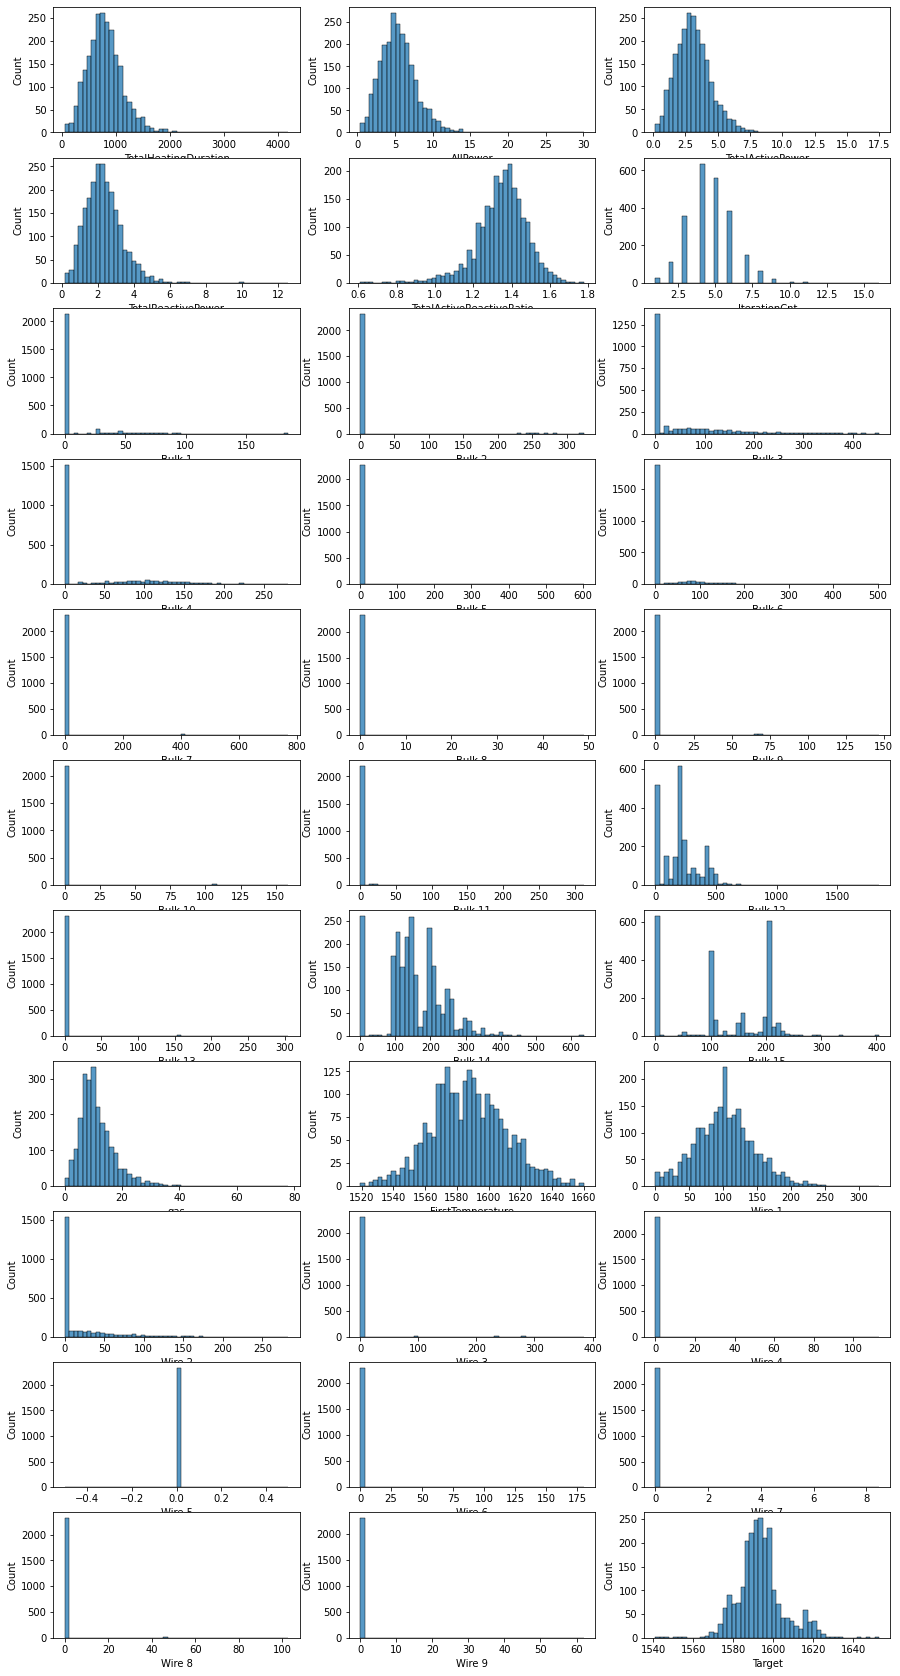

In [102]:
# визуализируем распределение всех признаков
fig = plt.figure(figsize=(15,30))

for i in range(data.shape[1]):
    
    fig.add_subplot(11, 3, i+1)
    sns.histplot(data.loc[:,data.columns[i]], bins=50)

plt.show()

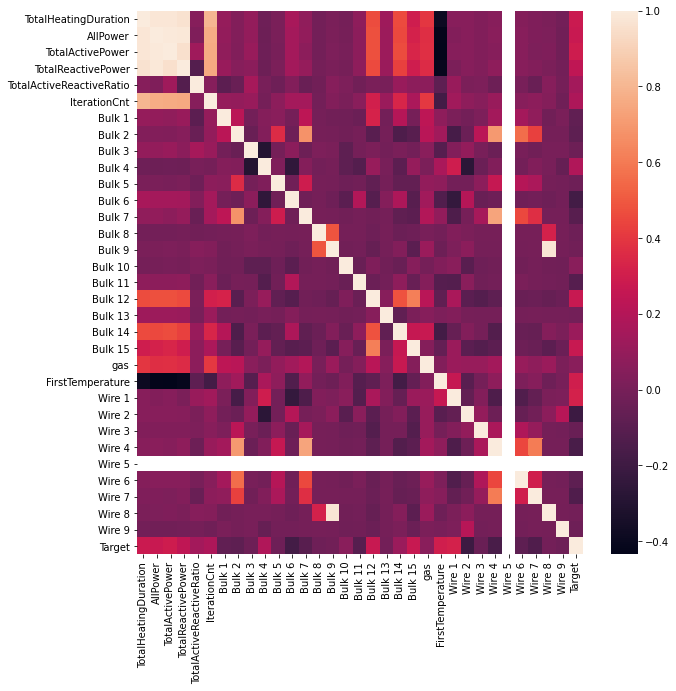

In [103]:
# построим карту корреляции признаков
fig = plt.figure(figsize=(10,10))
sns.heatmap(data.corr())
plt.show()

## Обучение моделей

In [104]:
target = data['Target']
features = data.drop('Target', axis=1)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

In [105]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1746, 32), (1746,), (583, 32), (583,))

### Случайный лес

In [106]:
# базовая модель случайного леса
rf = RandomForestRegressor(random_state=RANDOM_STATE)

In [107]:
%%time
# подбор гиперпараметров для случайного леса
params_rf = {
    'n_estimators': [47,48,49],
    'max_depth': [19,20,21],
    'min_samples_split': [4,5,6],
    'min_samples_leaf': [1,2], 
}

search_rf = GridSearchCV(rf, params_rf, cv=5, 
                          scoring='neg_mean_absolute_error').fit(X_train, y_train)

search_rf.best_score_

CPU times: total: 2min 58s
Wall time: 2min 58s


-6.016773013094129

In [ ]:
search_rf.best_params_ 

In [109]:
best_rf = search_rf.best_estimator_

### CatBoost

In [106]:
# базовая модель catboost
catb = CatBoostRegressor(random_state=RANDOM_STATE,
                        iterations=200,
                        learning_rate=0.1,
                        early_stopping_rounds=5,
                        task_type=TASK_TYPE
                        )

In [107]:
%%time
params_catb = {
    'depth': [5],
}

search_catb = GridSearchCV(catb, params_catb, cv=5,
                        scoring='neg_mean_absolute_error').fit(X_train, y_train, verbose=False) 
search_catb.best_score_

CPU times: user 2.56 s, sys: 127 ms, total: 2.69 s
Wall time: 16 s


-5.885515119816623

In [114]:
search_catb.best_params_

{'depth': 5}

In [108]:
best_catb = search_catb.best_estimator_

### Нейросеть

In [118]:
features_train, features_valid, target_train, target_valid = train_test_split(X_train, y_train, test_size=.2, random_state=RANDOM_STATE)

In [119]:
features_train.shape, features_valid.shape, target_train.shape, target_valid.shape

((1396, 32), (350, 32), (1396,), (350,))

In [120]:
device = torch.device(DEVICE)

In [122]:
# гиперпараметры нейросети
num_epochs = 2000
batch_size = 100
loss = nn.L1Loss() 
learning_rate = 0.01

In [123]:
# создаём тензоры
X_train_tensor = torch.from_numpy(np.array(features_train)).float().to(device)
X_valid_tensor = torch.from_numpy(np.array(features_valid)).float().to(device)
X_test_tensor = torch.from_numpy(np.array(X_test)).float().to(device)

y_train_tensor = torch.from_numpy(np.array(target_train)).float().to(device)
y_valid_tensor = torch.from_numpy(np.array(target_valid)).float().to(device) 
y_test_tensor = torch.from_numpy(np.array(y_test)).float().to(device) 

dataset_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataset_valid = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
dataset_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)


train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [124]:
class BN_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons,
                 act_1, act_2, act_3):
        super(BN_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.activation1 = act_1
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.activation2 = act_2
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.activation3 = act_3

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        x = self.activation3(x)

        return x

In [125]:
# инициализация весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_uniform_(layer.weight)

In [126]:
# задаём количество нейронов и функции активации
n_in_neurons = X_train_tensor.size(dim=1)
n_out_neurons = 1
n_hidden_neurons_1 = round(X_train_tensor.shape[1]*0.5)
n_hidden_neurons_2 = round(X_train_tensor.shape[1]*0.1)
act_1 = act_2 = act_3 = nn.ReLU()
num_batches = int(np.ceil(len(X_train_tensor)/batch_size))

In [127]:
best_mae = 1000000

In [128]:
bn_net = BN_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons,
                      act_1, act_2, act_3)
bn_net.apply(init_weights)
optimizer = torch.optim.Adam(bn_net.parameters(), lr=learning_rate)
bn_net = bn_net.to(device)

In [129]:
for epoch in range(num_epochs+1):
    bn_net.train()
    for batch in train_dataloader:
        data_train, target_train = batch   # просто выгружаем данные
        optimizer.zero_grad()
        preds = bn_net.forward(data_train).flatten()
        loss_value = loss(preds, target_train)
        loss_value.backward()
        optimizer.step()

    if epoch % 10 == 0:
        predicted_temp = []
        with torch.no_grad():
            bn_net.eval()
            for batch in valid_dataloader:
                data_valid, target_valid = batch # просто выгружаем данные

                valid_preds = bn_net.forward(data_valid).flatten()
                predicted_temp.append(valid_preds)
                L1_loss = loss(valid_preds, target_valid)

        predicted_temp = torch.cat(predicted_temp).cpu().detach().numpy()
        MAE = mean_absolute_error(y_valid_tensor.cpu().detach().numpy(), predicted_temp)

        print(f"epoch:{epoch}, MAE valid: {MAE}")
        
        if MAE < best_mae:
            best_mae = round(MAE,4)
            best_epoch = epoch
            best_model = bn_net 

epoch:0, MAE valid: 1593.2869873046875
epoch:10, MAE valid: 1578.2750244140625
epoch:20, MAE valid: 1498.278564453125
epoch:30, MAE valid: 1429.2598876953125
epoch:40, MAE valid: 1299.726318359375
epoch:50, MAE valid: 1230.574462890625
epoch:60, MAE valid: 1039.4949951171875
epoch:70, MAE valid: 659.5948486328125
epoch:80, MAE valid: 752.0733642578125
epoch:90, MAE valid: 155.25650024414062
epoch:100, MAE valid: 95.23931121826172
epoch:110, MAE valid: 58.9046745300293
epoch:120, MAE valid: 38.679080963134766
epoch:130, MAE valid: 35.593929290771484
epoch:140, MAE valid: 36.103572845458984
epoch:150, MAE valid: 25.992366790771484
epoch:160, MAE valid: 29.53424644470215
epoch:170, MAE valid: 23.78290367126465
epoch:180, MAE valid: 27.164859771728516
epoch:190, MAE valid: 18.004070281982422
epoch:200, MAE valid: 25.488353729248047
epoch:210, MAE valid: 26.83106803894043
epoch:220, MAE valid: 18.80370330810547
epoch:230, MAE valid: 34.070858001708984
epoch:240, MAE valid: 17.34952926635742

In [130]:
best_mae, best_epoch

(10.0624, 1650)

## Тестирование модели

### Качество на тесте

In [109]:
catb_preds = best_catb.predict(X_test)

In [110]:
mean_absolute_error(y_test, catb_preds)

5.869649271739596

Дополнительно ещё измерим коэффициент детерминации r2, чтобы оценить, насколько модель справляется лучше константной.

In [111]:
r2_score(y_test, catb_preds)

0.40132719458465915

Значение r2 = 0.4 говорит о том, что модель всё же способна лучше выявлять закономерности, чем просто предсказание константой. 
Однако, ещё есть, к чему стремиться. Не очень сильное значение метрики, скорей всего, связано с небольшим диапазоном предсказываемых температур, и потому все прогнозируемые значения, так или иначе, будут близки к среднему.

### Сравнение с константной моделью

In [145]:
preds = pd.Series([y_train.mean() for x in range(len(y_test))])

In [146]:
mean_absolute_error(y_test, preds)

7.960433944580989

Ещё одно подвтерждение тому, что наша модель работает получше константной.

### Оценка важности признаков

In [133]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

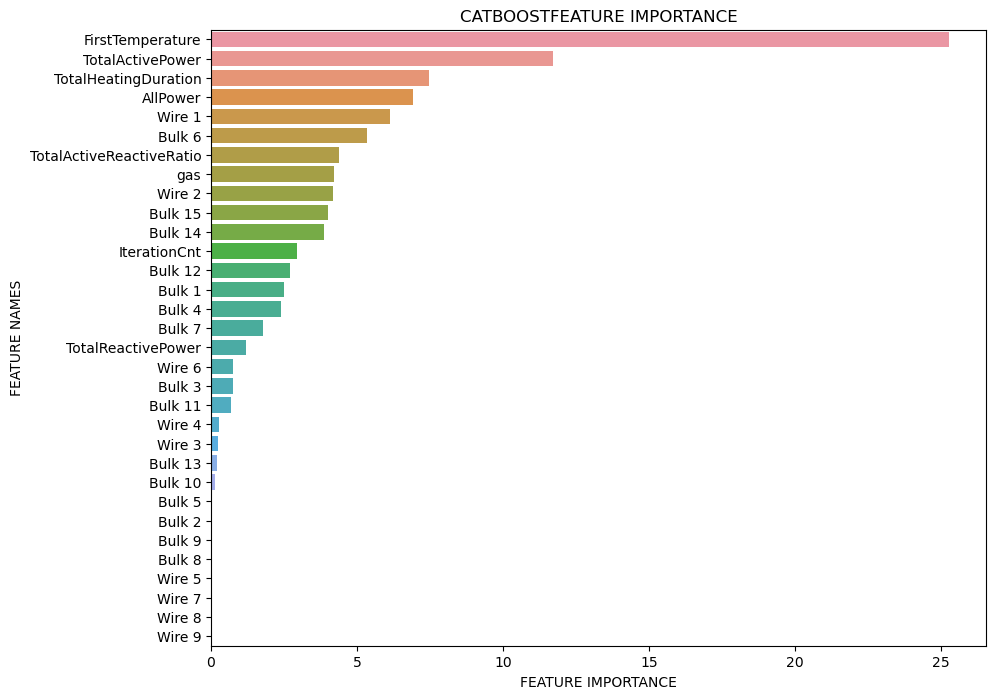

In [134]:
#plot the catboost result
plot_feature_importance(best_catb.get_feature_importance(),X_train.columns,'CATBOOST')

В топ-3 важности признаков вошли:
1. Начальная температура нагрева электродами
2. Общая активная мощность, используемая в партии
3. Общая длительность нагрева

Причём признак начальной температуры нагрева сильно вырывается вперёд. Это вполне логично: т.к. мы предсказываем температуру, то и значения температуры в обучающей выборке будет очень важным признаком. 

Помимо этого, мы видим, что активная мощность влияет больше, чем реактивная. И сможем это учитывать в дальнейшем при подготовке признаков.

Важность общей длительности нагрева тоже вполне закономерна - этот признак напрямую связан с температурой. По логике, чем больше длительность нагрева, тем меньше значение температуры. Но необязательно.

### Зависимость важного признака от целевой переменной

Теперь интересно проверить гипотезу о том, что чем больше длительность нагрева, тем меньше значение температур.

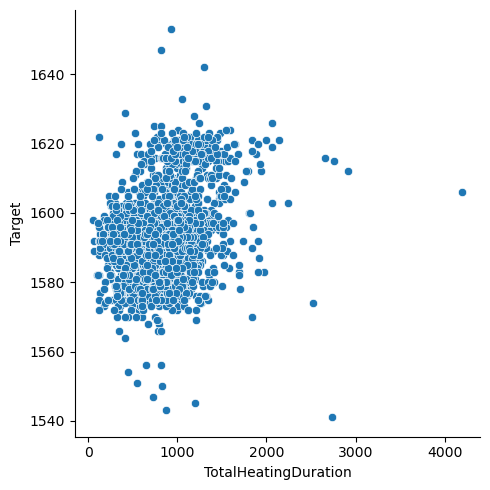

In [263]:
sns.relplot(data=data, x="TotalHeatingDuration", y="Target")

Какую-то очевидную линейную зависимость здесь выделить сложно, но всё-таки отчасти гипотеза подтвержается.

## Общий вывод

Чтобы оптимизировать производственные расходы путём контроля температуры сплава можно использовать машинное обучение. 

Наилучший результат показала модель градиентного бустинга.
Полученная метрика на тесте: МАЕ = 5.84. Пороговое условие выполнено, модель работает лучше константной.

Для дальнейшего улучшения решения можно ещё попробовать добавить больше признаков для обучения и увеличить количество данных.